In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

from evidently import Dataset
from evidently import DataDefinition
from evidently import Report
from evidently.presets import DataDriftPreset, RegressionPreset
from evidently.presets import RegressionPreset
# from evidently.presets import DatasetDriftMetric, RegressionQualityMetric
from evidently.ui.workspace import CloudWorkspace
from dotenv import load_dotenv

import warnings
warnings.filterwarnings('ignore')

load_dotenv()


True

In [118]:
token = os.getenv('EVIDENTLY_TOKEN')
project_id = os.getenv('EVIDENTLY_PROJECT_ID')

ws = CloudWorkspace(token=token, url="https://app.evidently.cloud")

project = ws.get_project(project_id)
project.description = "ML model monitoring for cancer death rate prediction with data drift detection"
project.save()

print(f"Evidently Cloud workspace connected successfully!")


Evidently Cloud workspace connected successfully!


In [119]:
df = pd.read_csv('cancer_reg.csv')

df.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


In [120]:
df.isnull().sum()

avgAnnCount                   0
avgDeathsPerYear              0
TARGET_deathRate              0
incidenceRate                 0
medIncome                     0
popEst2015                    0
povertyPercent                0
studyPerCap                   0
binnedInc                     0
MedianAge                     0
MedianAgeMale                 0
MedianAgeFemale               0
Geography                     0
AvgHouseholdSize              0
PercentMarried                0
PctNoHS18_24                  0
PctHS18_24                    0
PctSomeCol18_24            2285
PctBachDeg18_24               0
PctHS25_Over                  0
PctBachDeg25_Over             0
PctEmployed16_Over          152
PctUnemployed16_Over          0
PctPrivateCoverage            0
PctPrivateCoverageAlone     609
PctEmpPrivCoverage            0
PctPublicCoverage             0
PctPublicCoverageAlone        0
PctWhite                      0
PctBlack                      0
PctAsian                      0
PctOther

In [121]:
df.describe()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3.047000e+03,3047.000000,3047.000000,3047.000000,3047.000000,...,2438.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,606.338544,185.965868,178.664063,448.268586,47063.281917,1.026374e+05,16.878175,155.399415,45.272333,39.570725,...,48.453774,41.196324,36.252642,19.240072,83.645286,9.107978,1.253965,1.983523,51.243872,5.640306
std,1416.356223,504.134286,27.751511,54.560733,12040.090836,3.290592e+05,6.409087,529.628366,45.304480,5.226017,...,10.083006,9.447687,7.841741,6.113041,16.380025,14.534538,2.610276,3.517710,6.572814,1.985816
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,...,15.700000,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000
25%,76.000000,28.000000,161.200000,420.300000,38882.500000,1.168400e+04,12.150000,0.000000,37.700000,36.350000,...,41.000000,34.500000,30.900000,14.850000,77.296180,0.620675,0.254199,0.295172,47.763063,4.521419
50%,171.000000,61.000000,178.100000,453.549422,45207.000000,2.664300e+04,15.900000,0.000000,41.000000,39.600000,...,48.700000,41.100000,36.300000,18.800000,90.059774,2.247576,0.549812,0.826185,51.669941,5.381478
75%,518.000000,149.000000,195.200000,480.850000,52492.000000,6.867100e+04,20.400000,83.650776,44.000000,42.500000,...,55.600000,47.700000,41.550000,23.100000,95.451693,10.509732,1.221037,2.177960,55.395132,6.493677
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,...,78.900000,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,41.930251,78.075397,21.326165


In [122]:
df.columns = df.columns.str.replace(' ', '').str.lower()

df = df.dropna()

X = df.drop(columns=['target_deathrate', 'binnedinc', 'geography'])
y = df['target_deathrate']

X

,avganncount,avgdeathsperyear,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,medianagefemale,...,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
1,173.000000,70,411.600000,48127,43269,18.6,23.111234,33.0,32.2,33.7,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
3,427.000000,202,430.400000,44243,75882,17.1,342.637253,42.8,42.2,43.4,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,350.100000,49955,10321,12.5,0.000000,48.3,47.8,48.9,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
7,146.000000,71,404.000000,40189,20848,17.8,0.000000,51.7,50.8,52.5,...,33.1,25.9,50.9,24.1,89.406636,0.305159,1.889077,2.286268,48.967033,5.889179
14,2265.000000,901,440.700000,50083,490945,16.3,462.373586,37.2,35.7,38.7,...,50.6,42.5,36.5,21.4,89.038167,1.827041,2.315986,1.033625,48.188377,5.355836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033,1962.667684,7,453.549422,45353,1843,11.4,0.000000,45.7,43.8,49.2,...,52.7,43.9,32.2,9.2,97.960199,0.000000,0.547264,0.995025,57.780612,4.664723
3034,1962.667684,85,453.549422,45180,35788,15.0,1900.078239,38.2,36.5,40.0,...,52.3,46.2,34.4,17.4,87.718617,3.168048,1.610355,1.893068,50.730567,7.404551
3043,1962.667684,43,453.549422,48609,37118,18.8,377.175494,30.4,29.3,31.4,...,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,453.549422,51144,34536,15.0,1968.959926,30.9,30.5,31.2,...,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192


In [123]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (472, 31)
Test set size: (119, 31)


In [124]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on original test set
y_pred_original = rf_model.predict(X_test_scaled)

print("Model trained successfully!")


Model trained successfully!


In [125]:
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Evaluate model performance"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"=== {dataset_name} Model Performance ===")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print()

    return {'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate original model
original_metrics = evaluate_model(y_test, y_pred_original, "Original Test Set")


=== Original Test Set Model Performance ===
RMSE: 23.2674
MAE: 16.5444
R²: 0.2365



In [126]:
from evidently import Regression

schema = DataDefinition(
    regression=[Regression(target="target_deathrate")],
    numerical_columns=X.columns.tolist(),
    # categorical_columns=categorical_columns,
)


# Create reference dataset (training data)
train_data_with_target = X_train.copy()
train_data_with_target['target_deathrate'] = y_train

reference_dataset = Dataset.from_pandas(
    train_data_with_target,
    data_definition=schema
)

print("Reference dataset created for monitoring")


Reference dataset created for monitoring


In [127]:
def create_modified_dataset_and_analyze(X_test_original, y_test_original, modifications, modification_name):
    """
    Create modified dataset and analyze drift
    """
    print(f"\n{'='*50}")
    print(f"ANALYSIS: {modification_name}")
    print(f"{'='*50}")

    # Create a copy of the test dataset
    X_test_modified = X_test_original.copy()

    # Apply modifications
    for col, change in modifications.items():
        if col in X_test_modified.columns:
            X_test_modified[col] = X_test_modified[col] + change
            print(f"Modified {col}: added {change}")
        else:
            print(f"Warning: Column '{col}' not found in dataset")

    # Scale the modified features
    X_test_modified_scaled = scaler.transform(X_test_modified)

    # Make predictions
    y_pred_modified = rf_model.predict(X_test_modified_scaled)

    # Evaluate model performance
    modified_metrics = evaluate_model(y_test_original, y_pred_modified, f"{modification_name}")

    # Create current dataset for drift analysis
    current_data_with_target = X_test_modified.copy()
    current_data_with_target['target'] = y_test_original  # Actual target values
    current_data_with_target['prediction'] = y_pred_modified  # Model predictions

    # Update schema to include both target and prediction
    from evidently import Regression
    schema = DataDefinition(
        regression=[Regression(target="target")],  # Changed from "target_deathrate" to "target"
        numerical_columns=numerical_columns,
    )

    current_dataset = Dataset.from_pandas(
        current_data_with_target,
        data_definition=schema
    )

    # Also need to update reference dataset to have the same structure
    reference_data_with_predictions = X_train.copy()
    reference_data_with_predictions['target'] = y_train  # Actual target values
    # Get predictions for training data
    y_train_pred = rf_model.predict(X_train_scaled)
    reference_data_with_predictions['prediction'] = y_train_pred

    reference_dataset = Dataset.from_pandas(
        reference_data_with_predictions,
        data_definition=schema
    )

    # Generate drift report
    drift_report = Report([
        DataDriftPreset(),
    ])

    eval = drift_report.run(current_dataset, reference_dataset)
    eval.save_html('report.html')

    # Upload to Evidently Cloud
    try:
        ws.add_run(project.id, eval, include_data=False, name=modification_name)
        print(f"✅ Report uploaded to Evidently Cloud dashboard")
    except Exception as e:
        print(f"⚠️  Failed to upload to cloud: {e}")

    return modified_metrics, drift_report


# Scenario A: Decrease medianincome by 40,000

In [128]:
modifications_a = {'medincome': -40000}
metrics_a, report_a = create_modified_dataset_and_analyze(
    X_test, y_test, modifications_a, "Scenario A: MedianIncome -40K"
)



ANALYSIS: Scenario A: MedianIncome -40K
Modified medincome: added -40000
=== Scenario A: MedianIncome -40K Model Performance ===
RMSE: 23.9289
MAE: 17.3770
R²: 0.1925

✅ Report uploaded to Evidently Cloud dashboard


# Scenario A + B: MedianIncome -40K + PovertyPercent +20

In [129]:
modifications_ab = {
    'medincome': -40000,
    'povertypercent': 20
}
metrics_ab, report_ab = create_modified_dataset_and_analyze(
    X_test, y_test, modifications_ab, "Scenario A & B: MedianIncome -40K & PovertyPercent +20"
)


ANALYSIS: Scenario A & B: MedianIncome -40K & PovertyPercent +20
Modified medincome: added -40000
Modified povertypercent: added 20
=== Scenario A & B: MedianIncome -40K & PovertyPercent +20 Model Performance ===
RMSE: 24.1225
MAE: 17.6947
R²: 0.1794

✅ Report uploaded to Evidently Cloud dashboard


# Scenario A + B + C: All modifications

In [130]:
modifications_abc = {
    'medincome': -40000,
    'povertypercent': 20,
    'avghouseholdsize': 2
}
metrics_abc, report_abc = create_modified_dataset_and_analyze(
    X_test, y_test, modifications_abc, "Scenario A & B & C: All Modifications"
)



ANALYSIS: Scenario A & B & C: All Modifications
Modified medincome: added -40000
Modified povertypercent: added 20
Modified avghouseholdsize: added 2
=== Scenario A & B & C: All Modifications Model Performance ===
RMSE: 23.6967
MAE: 16.8669
R²: 0.2081

✅ Report uploaded to Evidently Cloud dashboard


# Evidently Dashboard

![evidently.png](evidently.png)


SUMMARY OF ALL SCENARIOS
                         rmse        mae        r2
Original            23.267406  16.544420  0.236550
Scenario A          23.928914  17.377034  0.192522
Scenario A & B      24.122473  17.694748  0.179406
Scenario A & B & C  23.696717  16.866908  0.208117


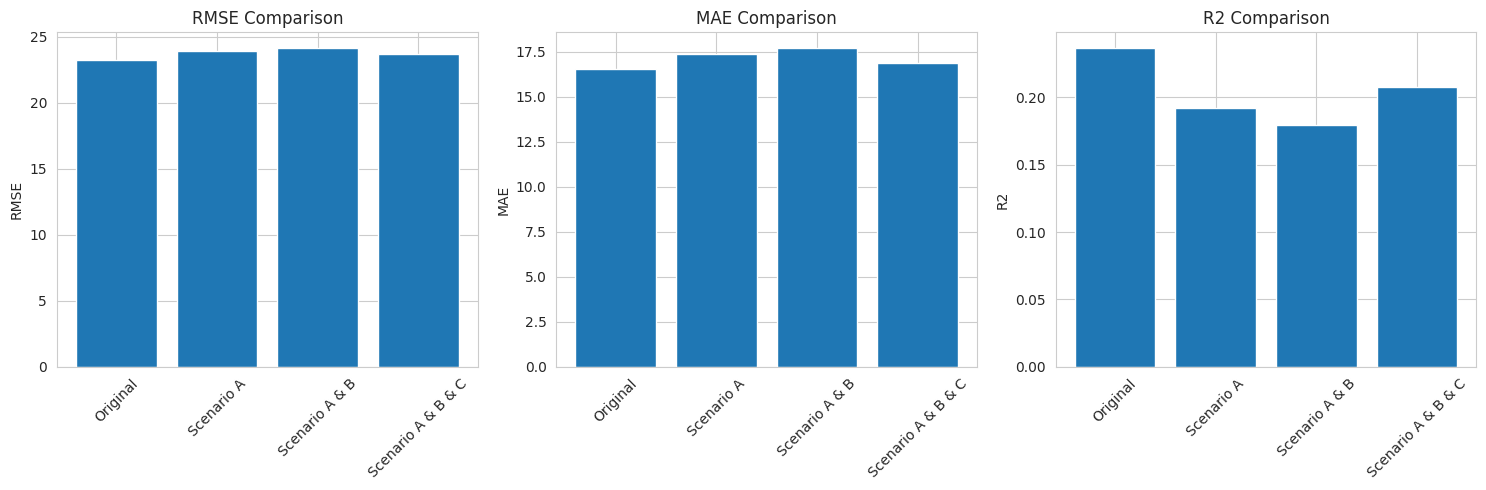


KEY FINDINGS
1. MODEL PERFORMANCE CHANGES:
   Scenario A: R² change = -0.0440, RMSE change = +0.6615
   Scenario A & B: R² change = -0.0571, RMSE change = +0.8551
   Scenario A & B & C: R² change = -0.0284, RMSE change = +0.4293


In [131]:
# Create summary comparison
print("\n" + "=" * 60)
print("SUMMARY OF ALL SCENARIOS")
print("=" * 60)

scenarios = {
    'Original': original_metrics,
    'Scenario A': metrics_a,
    'Scenario A & B': metrics_ab,
    'Scenario A & B & C': metrics_abc
}

summary_df = pd.DataFrame(scenarios).T
print(summary_df)

# Visualize the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['rmse', 'mae', 'r2']
for i, metric in enumerate(metrics_to_plot):
    values = [scenarios[scenario][metric] for scenario in scenarios.keys()]
    axes[i].bar(scenarios.keys(), values)
    axes[i].set_title(f'{metric.upper()} Comparison')
    axes[i].set_ylabel(metric.upper())
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("KEY FINDINGS")
print("=" * 60)

print("1. MODEL PERFORMANCE CHANGES:")
for scenario in scenarios.keys():
    if scenario != 'Original':
        r2_change = scenarios[scenario]['r2'] - scenarios['Original']['r2']
        rmse_change = scenarios[scenario]['rmse'] - scenarios['Original']['rmse']
        print(f"   {scenario}: R² change = {r2_change:+.4f}, RMSE change = {rmse_change:+.4f}")